# Imports

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from funcs import *
from stats import *

from iminuit import Minuit
from iminuit.cost import LeastSquares, ExtendedBinnedNLL

# Funcs

In [199]:
def V_sott(t, R, L, C, fase, V_o):
    '''tensione resistenza in regime sottosmorzato'''
    gamma = R/(2*L)
    omega = 1/np.sqrt(float(L*C))

    return R*C*V_o*np.exp(-gamma*t)*(gamma*np.cos(omega*t + fase) + omega*np.sin(omega*t + fase))

def V_crit(t, R, L, V_o):
    '''tensione resistenza in regime criticamente smorzato'''
    gamma = R/(2*L)
    
    return V_o * R * (gamma**2) * t * np.exp(-gamma*t)

def V_sovr2(t, R, L, C, I_o):
    '''tensione resistenza in regime sovrasmorzato'''
    gamma = R/(2*L)
    omega = 1/np.sqrt(float(L*C))
    betha = np.sqrt(np.power(gamma,2) - np.power(omega,2))
    
    return I_o*R*np.exp(-gamma*t)*(np.exp(betha*t) - np.exp(-betha*t))

def V_sovr(t, R, L, C, V_o):
    '''tensione resistenza in regime sovrasmorzato'''
    gamma = R/(2*L)
    omega = 1/np.sqrt(float(L*C))
    betha = np.sqrt(np.power(gamma,2) - np.power(omega,2))
    
    return V_o*R*(omega**2)*(np.exp(-t*(gamma-betha)) - np.exp(-t*(gamma+betha)))/(2*betha)

# RLC

In [200]:
R_L = 39.4
R_g = 50
C_val = 49e-9
L_int = 52.37e-3
C_int = 49.35e-9

chi = []

R = []
L = []
C = []
R_err = []
L_err = []
C_err = []

# R = 30 $\Omega$

87


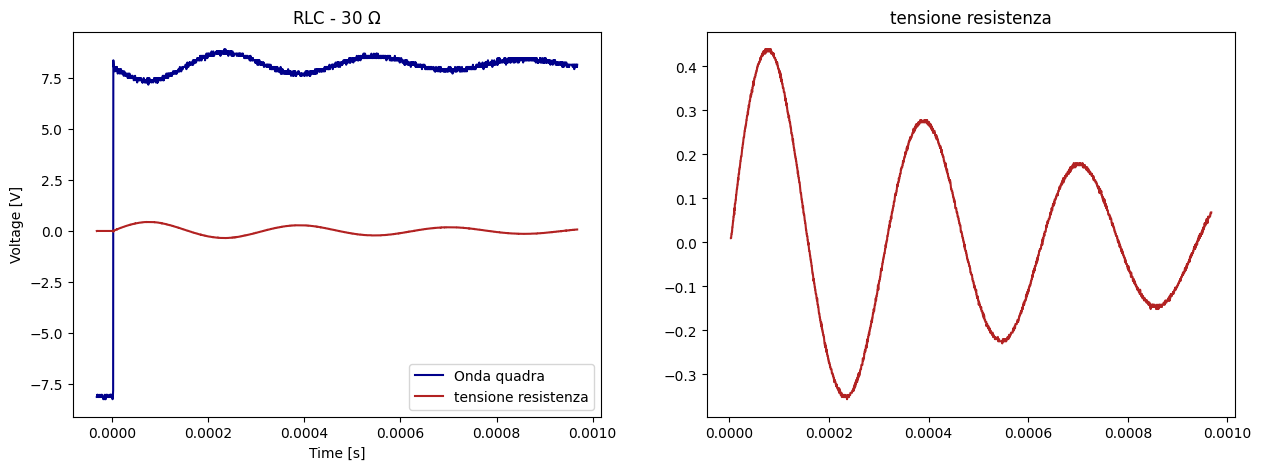

In [201]:
RLC_30_quadra, RLC_30_res, RLC_30_ind = get_data("data/RLC_30/")
if RLC_30_ind[1] == None:   RLC_30_ind = RLC_30_quadra[0], (RLC_30_quadra[1] - RLC_30_res[1])

cut = True

i = 0
if cut:
    v = RLC_30_quadra[1][0]
    while(v < np.max(RLC_30_quadra[1][:100])):
        v = RLC_30_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 30 $\Omega$')
plt.plot(RLC_30_quadra[0][:],RLC_30_quadra[1][:], c='darkblue')
plt.plot(RLC_30_res[0][:],  RLC_30_res[1][:],   c='firebrick')
# plt.plot(RLC_30_ind[0][:],  RLC_30_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_30_res[0][i:],  RLC_30_res[1][i:],   c='firebrick')

In [202]:
c = LeastSquares(RLC_30_res[0][87:], RLC_30_res[1][87:], 0.004, V_sott)
m = Minuit(c, R=30+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

In [203]:
Latex("$\Delta R = {:.2f} \Omega$  $\Delta L = {:.2f} mH \n\Delta C = {:.2f} nF$".format((m.values['R'] - (30+R_g+R_L)), (m.values['L'] - L_int)*1e3, (m.values['C'] - C_int)*1e9))

<IPython.core.display.Latex object>

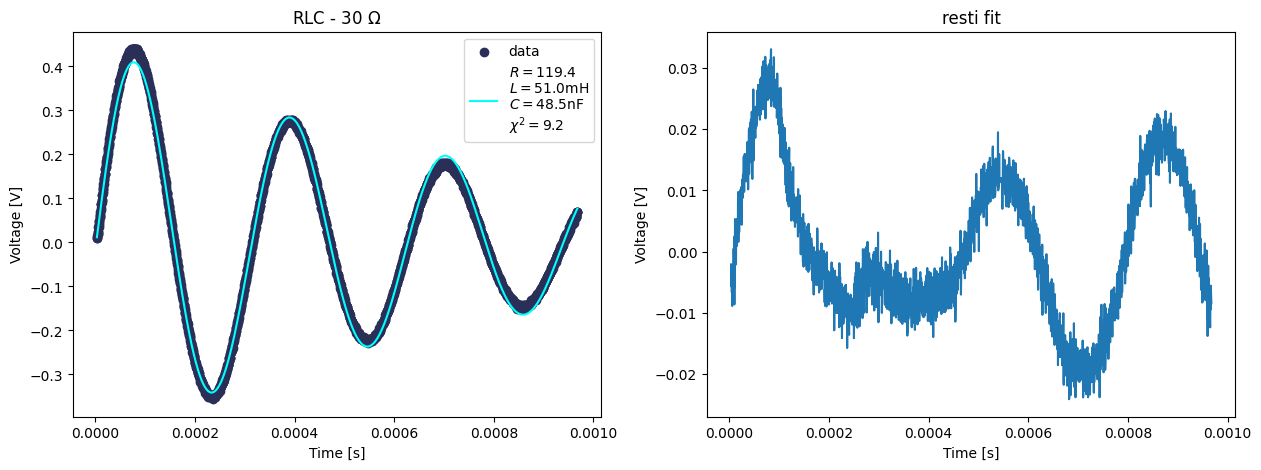

In [204]:
plt.subplots(1,2, figsize=(15,5))

plt.subplot(121)
plt.title('RLC - 30 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.scatter(RLC_30_res[0][87:],RLC_30_res[1][87:], c='#292f56',label='data')
plt.plot(RLC_30_res[0][87:], V_sott(RLC_30_res[0][87:], m.values['R'], m.values['L'], m.values['C'], m.values['fase'], m.values['V_o']), c='cyan', label=f'$R = {round(m.values["R"],1)}$'+'\n'+f'$L = {round(m.values["L"]*1e3,1)}$'+'mH\n'+f'$C = {round(m.values["C"]*1e9,1)}$'+'nF\n'+f'$\chi^2 = {round(m.fval/m.ndof,1)}$')
plt.legend()

plt.subplot(122)
plt.title('resti fit')
plt.ylabel('Voltage [V]')
plt.xlabel('Time [s]')
plt.plot(RLC_30_res[0][87:], RLC_30_res[1][87:] - V_sott(RLC_30_res[0][87:], m.values['R'], m.values['L'], m.values['C'], m.values['fase'], m.values['V_o']))

plt.savefig('imgs/RLC/RLC_30.pdf')

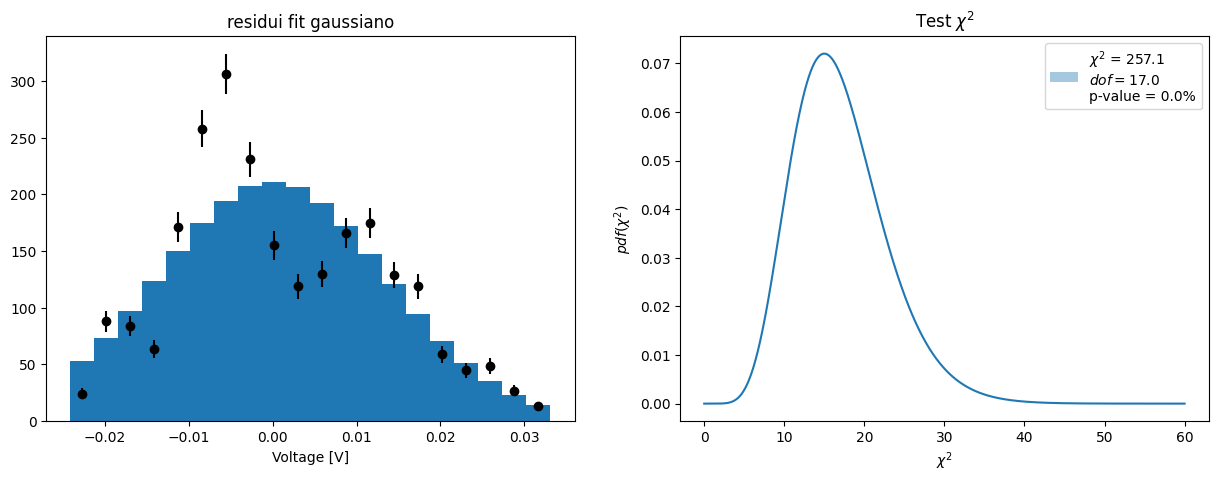

In [205]:
data = RLC_30_res[1][87:] - V_sott(RLC_30_res[0][87:], m.values['R'], m.values['L'], m.values['C'], m.values['fase'], m.values['V_o'])
a,b = np.histogram(data, bins=20)
c_ = ExtendedBinnedNLL(a, b, normal_scaled_cdf)
m_ = Minuit(c_, mu=0, sigma=1, scale = 1000)
m_.migrad()
m_.hesse()

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('residui fit gaussiano')
plt.xlabel('Voltage [V]')
m_.visualize()

plt.subplot(122)
chi_test(m_.fval, m_.ndof,60)

plt.savefig('imgs/RLC/RLC_30_res.pdf')

# R = 100 $\Omega$

87


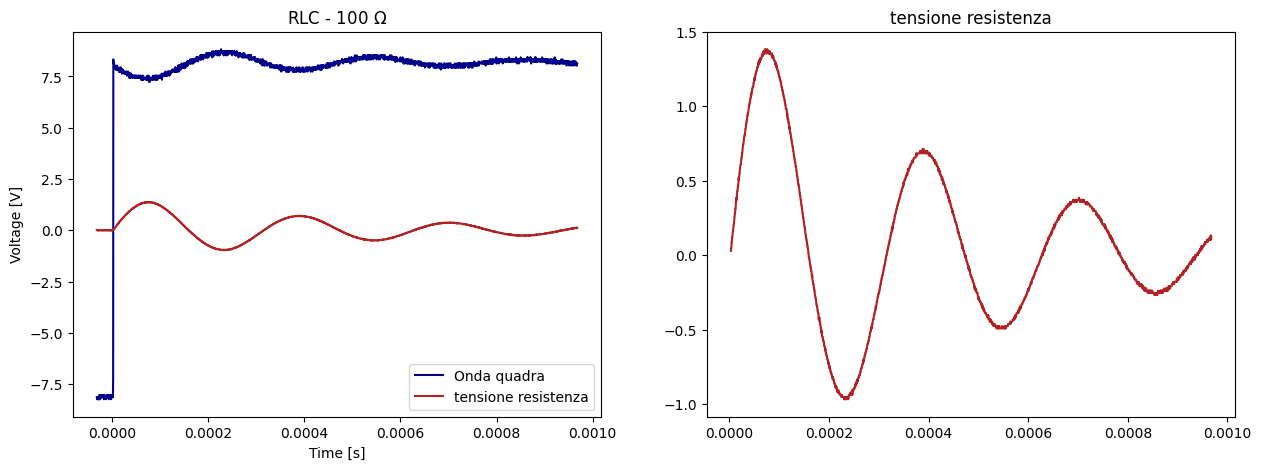

In [206]:
RLC_100_quadra, RLC_100_res, RLC_100_ind = get_data("data/RLC_100/")
if RLC_100_ind[1] == None:   RLC_100_ind = RLC_100_quadra[0], (RLC_100_quadra[1] - RLC_100_res[1])

cut = True

i = 0
if cut:
    v = RLC_100_quadra[1][0]
    while(v < np.max(RLC_100_quadra[1][:100])):
        v = RLC_100_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 100 $\Omega$')
plt.plot(RLC_100_quadra[0][:],RLC_100_quadra[1][:], c='darkblue')
plt.plot(RLC_100_res[0][:],  RLC_100_res[1][:],   c='firebrick')
# plt.plot(RLC_100_ind[0][:],  RLC_100_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_100_res[0][i:],  RLC_100_res[1][i:],   c='firebrick')

In [207]:
c = LeastSquares(RLC_100_res[0][87:], RLC_100_res[1][87:], 0.01, V_sott)
m = Minuit(c, R=100+R_g+R_L, L=L_int, C=C_int, fase=-0.0001, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

In [208]:
resti = [i-j for i,j in zip(RLC_100_res[1][87:], V_sott(RLC_100_res[0][87:], m.values['R'],m.values['L'], m.values['C'], m.values['fase'], m.values['V_o']))]
plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 100 $\Omega$')
plt.plot(RLC_100_res[0][87:],RLC_100_res[1][87:], c='darkblue')
plt.plot(RLC_100_res[0][87:],  V_sott(RLC_100_res[0][87:], m.values['R'],m.values['L'], m.values['C'],m.values['fase'], m.values['V_o']),   c='firebrick')

plt.subplot(122)
plt.title('Resti fit')
plt.plot(RLC_100_res[0][87:],  resti,   c='firebrick')


## R = 300 $\Omega$

87


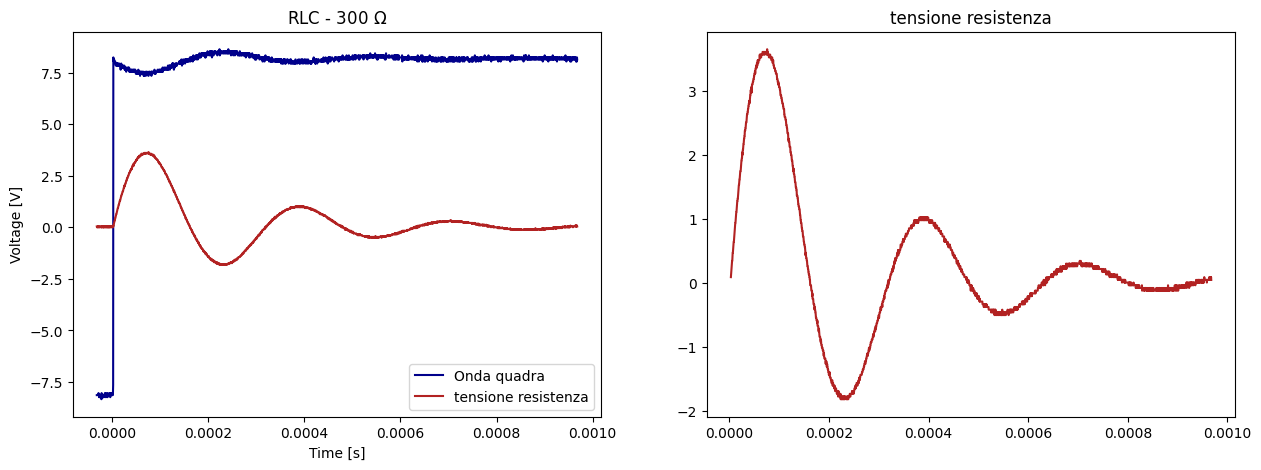

In [209]:
RLC_300_quadra, RLC_300_res, RLC_300_ind = get_data("data/RLC_300/")
if RLC_300_ind[1] == None:   RLC_300_ind = RLC_300_quadra[0], (RLC_300_quadra[1] - RLC_300_res[1])

cut = True

i = 0
if cut:
    v = RLC_300_quadra[1][0]
    while(v < np.max(RLC_300_quadra[1][:300])):
        v = RLC_300_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 300 $\Omega$')
plt.plot(RLC_300_quadra[0][:],RLC_300_quadra[1][:], c='darkblue')
plt.plot(RLC_300_res[0][:],  RLC_300_res[1][:],   c='firebrick')
# plt.plot(RLC_300_ind[0][:],  RLC_300_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_300_res[0][i:],  RLC_300_res[1][i:],   c='firebrick')

In [210]:
c = LeastSquares(RLC_300_res[0][87:], RLC_300_res[1][87:], 0.01, V_sott)
m = Minuit(c, R=300+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

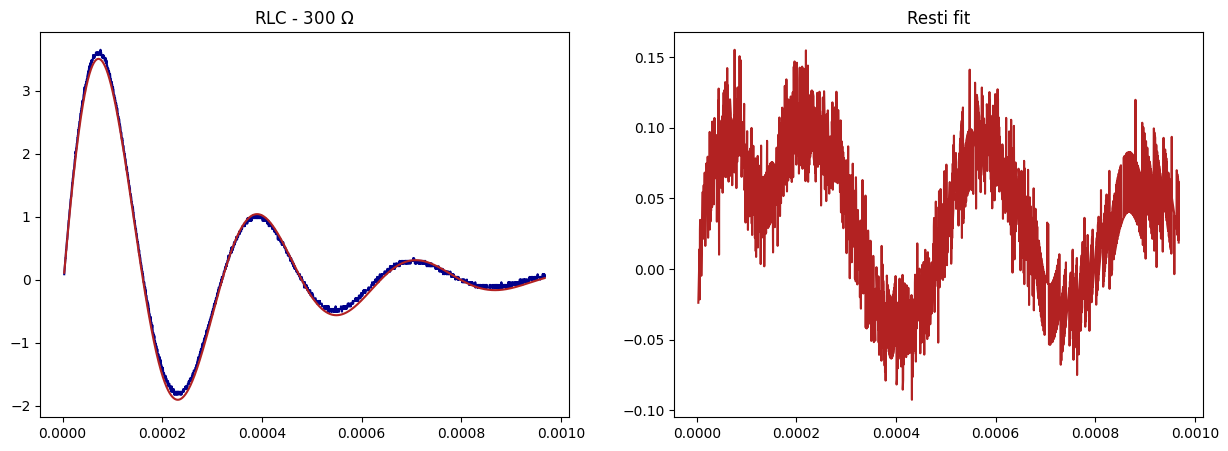

In [211]:
resti = [i-j for i,j in zip(RLC_300_res[1][87:], V_sott(RLC_300_res[0][87:], m.values['R'],m.values['L'], m.values['C'],m.values['fase'], m.values['V_o']))]
plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 300 $\Omega$')
plt.plot(RLC_300_res[0][87:],RLC_300_res[1][87:], c='darkblue')
plt.plot(RLC_300_res[0][87:],  V_sott(RLC_300_res[0][87:], m.values['R'],m.values['L'], m.values['C'],m.values['fase'], m.values['V_o']),   c='firebrick')

plt.subplot(122)
plt.title('Resti fit')
plt.plot(RLC_300_res[0][87:],  resti,   c='firebrick')

# R = 700 $\Omega$

87


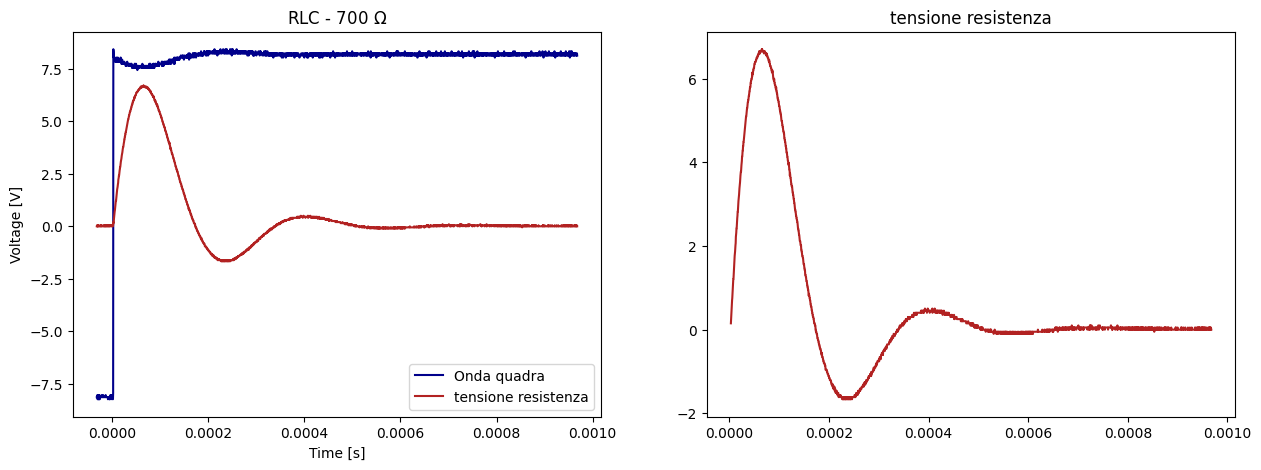

In [212]:
RLC_700_quadra, RLC_700_res, RLC_700_ind = get_data("data/RLC_700/")
if RLC_700_ind[1] == None:   RLC_700_ind = RLC_700_quadra[0], (RLC_700_quadra[1] - RLC_700_res[1])

cut = True

i = 0
if cut:
    v = RLC_700_quadra[1][0]
    while(v < np.max(RLC_700_quadra[1][:700])):
        v = RLC_700_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 700 $\Omega$')
plt.plot(RLC_700_quadra[0][:],RLC_700_quadra[1][:], c='darkblue')
plt.plot(RLC_700_res[0][:],  RLC_700_res[1][:],   c='firebrick')
# plt.plot(RLC_700_ind[0][:],  RLC_700_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_700_res[0][i:],  RLC_700_res[1][i:],   c='firebrick')

In [213]:
c = LeastSquares(RLC_700_res[0][87:], RLC_700_res[1][87:], 0.01, V_sott)
m = Minuit(c, R=700+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

In [214]:
Latex("$\Delta R = {:.2f} \Omega$  $\Delta L = {:.2f} mH \n\Delta C = {:.2f} nF$".format((m.values['R'] - (700+R_g+R_L)), (m.values['L'] - L_int)*1e3, (m.values['C'] - C_int)*1e9))

<IPython.core.display.Latex object>

# R = 1000 $\Omega$

87


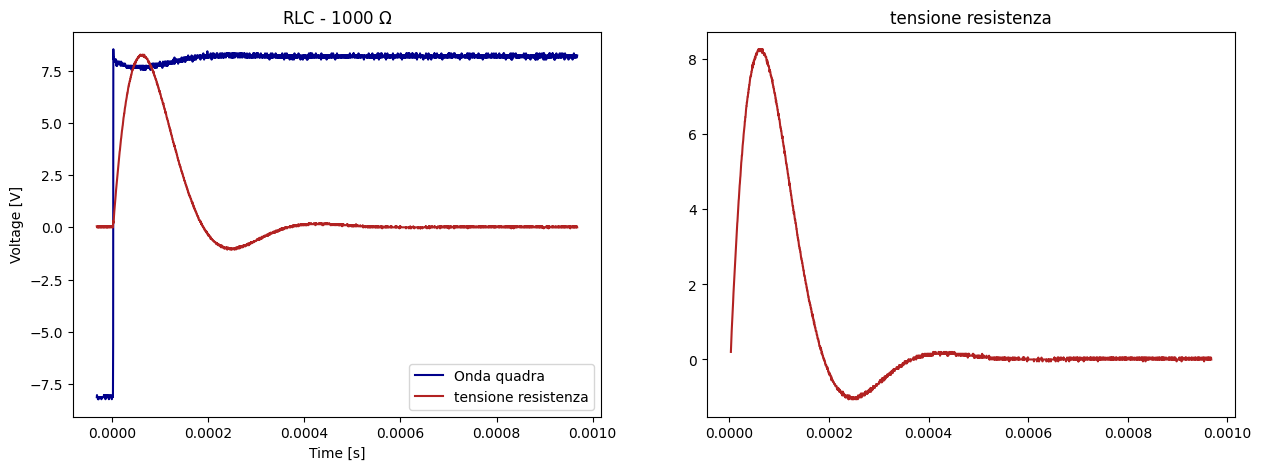

In [215]:
RLC_1000_quadra, RLC_1000_res, RLC_1000_ind = get_data("data/RLC_1000/")
if RLC_1000_ind[1] == None:   RLC_1000_ind = RLC_1000_quadra[0], (RLC_1000_quadra[1] - RLC_1000_res[1])

cut = True

i = 0
if cut:
    v = RLC_1000_quadra[1][0]
    while(v < np.max(RLC_1000_quadra[1][:1000])):
        v = RLC_1000_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 1000 $\Omega$')
plt.plot(RLC_1000_quadra[0][:],RLC_1000_quadra[1][:], c='darkblue')
plt.plot(RLC_1000_res[0][:],  RLC_1000_res[1][:],   c='firebrick')
# plt.plot(RLC_1000_ind[0][:],  RLC_1000_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_1000_res[0][i:],  RLC_1000_res[1][i:],   c='firebrick')

In [216]:
c = LeastSquares(RLC_1000_res[0][87:], RLC_1000_res[1][87:], 0.01, V_sott)
m = Minuit(c, R=1000+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

# R = 1400 $\Omega$

In [217]:
RLC_1400_quadra, RLC_1400_res, RLC_1400_ind = get_data("data/RLC_1400/")
if RLC_1400_ind[1] == None:   RLC_1400_ind = RLC_1400_quadra[0], (RLC_1400_quadra[1] - RLC_1400_res[1])

cut = True

i = 0
if cut:
    v = RLC_1400_quadra[1][0]
    while(v < np.max(RLC_1400_quadra[1][:1400])):
        v = RLC_1400_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 1400 $\Omega$')
plt.plot(RLC_1400_quadra[0][:],RLC_1400_quadra[1][:], c='darkblue')
plt.plot(RLC_1400_res[0][:],  RLC_1400_res[1][:],   c='firebrick')
# plt.plot(RLC_1400_ind[0][:],  RLC_1400_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_1400_res[0][i:],  RLC_1400_res[1][i:],   c='firebrick')

237


In [218]:
c = LeastSquares(RLC_1400_res[0][237:], RLC_1400_res[1][237:], 0.01, V_sott)
m = Minuit(c, R=1400+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

# R = 1500 $\Omega$

237


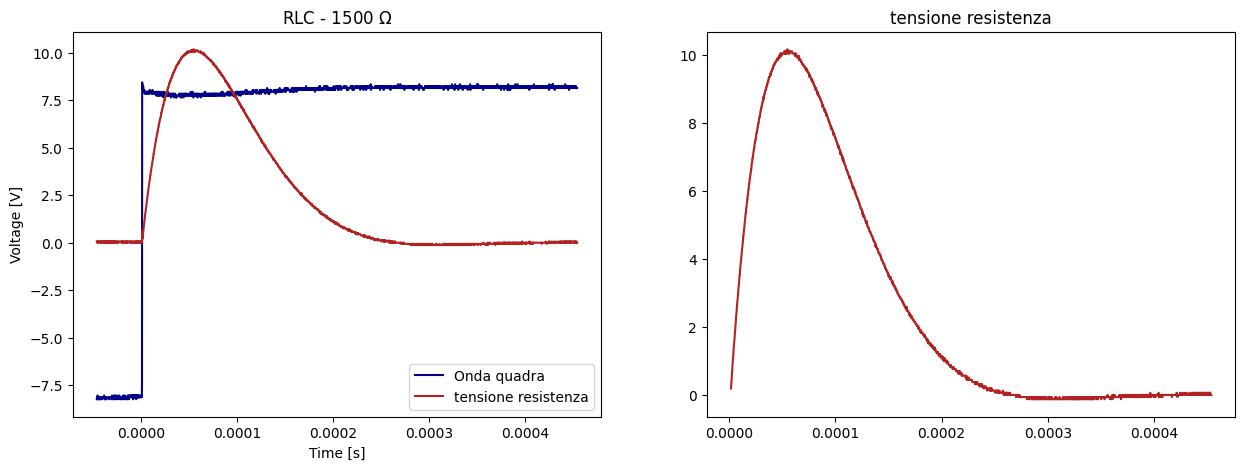

In [219]:
RLC_1500_quadra, RLC_1500_res, RLC_1500_ind = get_data("data/RLC_1500/")
if RLC_1500_ind[1] == None:   RLC_1500_ind = RLC_1500_quadra[0], (RLC_1500_quadra[1] - RLC_1500_res[1])

cut = True

i = 0
if cut:
    v = RLC_1500_quadra[1][0]
    while(v < np.max(RLC_1500_quadra[1][:1500])):
        v = RLC_1500_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 1500 $\Omega$')
plt.plot(RLC_1500_quadra[0][:],RLC_1500_quadra[1][:], c='darkblue')
plt.plot(RLC_1500_res[0][:],  RLC_1500_res[1][:],   c='firebrick')
# plt.plot(RLC_1500_ind[0][:],  RLC_1500_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_1500_res[0][i:],  RLC_1500_res[1][i:],   c='firebrick')

In [220]:
c = LeastSquares(RLC_1500_res[0][237:], RLC_1500_res[1][237:], 0.01, V_sott)
m = Minuit(c, R=1500+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

# R = 1540 $\Omega$

237


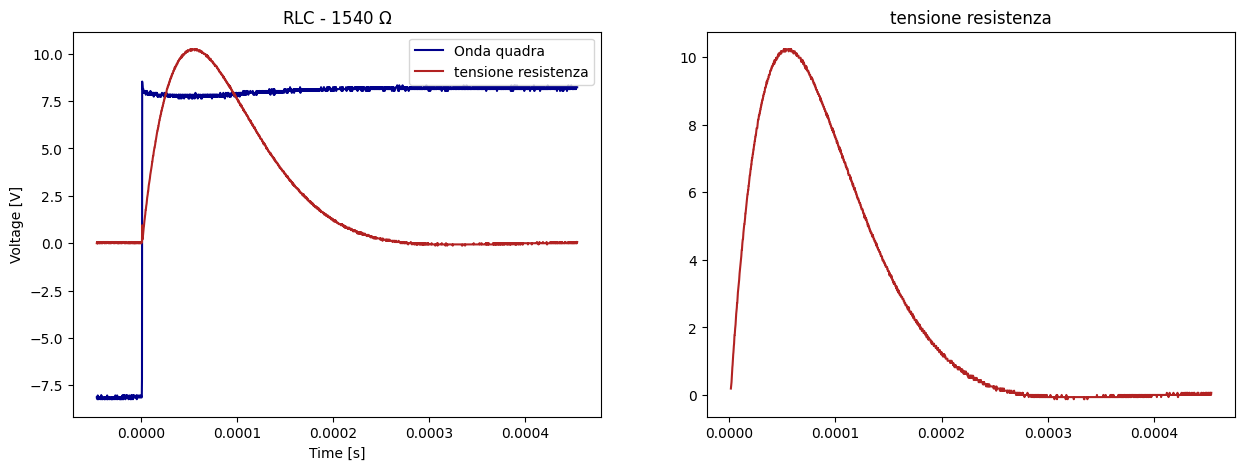

In [221]:
RLC_1540_quadra, RLC_1540_res, RLC_1540_ind = get_data("data/RLC_1540/")
if RLC_1540_ind[1] == None:   RLC_1540_ind = RLC_1540_quadra[0], (RLC_1540_quadra[1] - RLC_1540_res[1])

cut = True

i = 0
if cut:
    v = RLC_1540_quadra[1][0]
    while(v < np.max(RLC_1540_quadra[1][:1540])):
        v = RLC_1540_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 1540 $\Omega$')
plt.plot(RLC_1540_quadra[0][:],RLC_1540_quadra[1][:], c='darkblue')
plt.plot(RLC_1540_res[0][:],  RLC_1540_res[1][:],   c='firebrick')
# plt.plot(RLC_1540_ind[0][:],  RLC_1540_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_1540_res[0][i:],  RLC_1540_res[1][i:],   c='firebrick')

In [222]:
c = LeastSquares(RLC_1540_res[0][237:], RLC_1540_res[1][237:], 0.01, V_sott)
m = Minuit(c, R=1540+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, False, False, False, False]
m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()
chi.append(m.fval/m.ndof)
R.append(m.values['R'])
L.append(m.values['L'])
C.append(m.values['C'])
R_err.append(m.errors['R'])
L_err.append(m.errors['L'])
C_err.append(m.errors['C'])

# R = 1570 $\Omega$

237


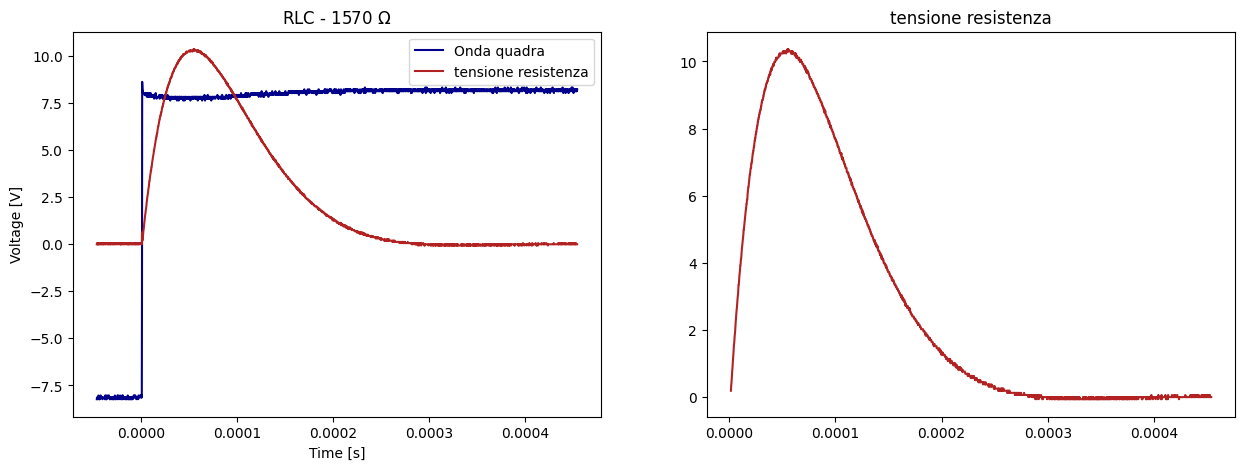

In [223]:
RLC_1570_quadra, RLC_1570_res, RLC_1570_ind = get_data("data/RLC_1570/")
if RLC_1570_ind[1] == None:   RLC_1570_ind = RLC_1570_quadra[0], (RLC_1570_quadra[1] - RLC_1570_res[1])

cut = True

i = 0
if cut:
    v = RLC_1570_quadra[1][0]
    while(v < np.max(RLC_1570_quadra[1][:1570])):
        v = RLC_1570_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 1570 $\Omega$')
plt.plot(RLC_1570_quadra[0][:],RLC_1570_quadra[1][:], c='darkblue')
plt.plot(RLC_1570_res[0][:],  RLC_1570_res[1][:],   c='firebrick')
# plt.plot(RLC_1570_ind[0][:],  RLC_1570_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_1570_res[0][i:],  RLC_1570_res[1][i:],   c='firebrick')

In [242]:
c = LeastSquares(RLC_1570_res[0][237:], RLC_1570_res[1][237:], 0.0001, V_sott)
m = Minuit(c, R=1570+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [False, False, False, False, False]
# m.limits['L', 'C'] = (51e-3, 54e-3), (48e-9, 51e-9)
m.migrad()
m.hesse()

# chi.append(m.fval/m.ndof)
# R.append(m.values['R'])
# L.append(m.values['L'])
# C.append(m.values['C'])
# R_err.append(m.errors['R'])
# L_err.append(m.errors['L'])
# C_err.append(m.errors['C'])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.425e+08 (χ²/ndof = 151739.1)│              Nfcn = 339              │
│ EDM = 5.13e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │2.506631e3 │0.000008e3 │            │            │         │         │       │
│ 1 │ L    │74.29298e-3│0.00024e-3 │            │            │         │         │       │
│ 2 │ C    │112.6713e-9│ 0.0005e-9 │            │            │         │         │       │
│ 3 │ fase │-1.0115889 │ 0.0000014 │            │            │         │         │       │
│ 4 │ V_o  │ 8.290731  │ 0.000018  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────────────────────────────────────────────────────────────────────────┐
│      │                  R                  L                  C               fase                V_o │
├──────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│    R │           6.98e-05         1.84073e-9 -1.88780298459e-15         -3.4689e-9          -41.32e-9 │
│    L │         1.84073e-9           5.76e-14      -87.51831e-21           0.03e-12           0.05e-12 │
│    C │ -1.88780298459e-15      -87.51831e-21           2.88e-25     -526.39427e-21    -6.98395538e-18 │
│ fase │         -3.4689e-9           0.03e-12     -526.39427e-21              2e-12           21.4e-12 │
│  V_o │          -41.32e-9           0.05e-12    -6.98395538e-18           21.4e-12           3.34e-10 │
└──────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

# R = 2000 $\Omega$

67


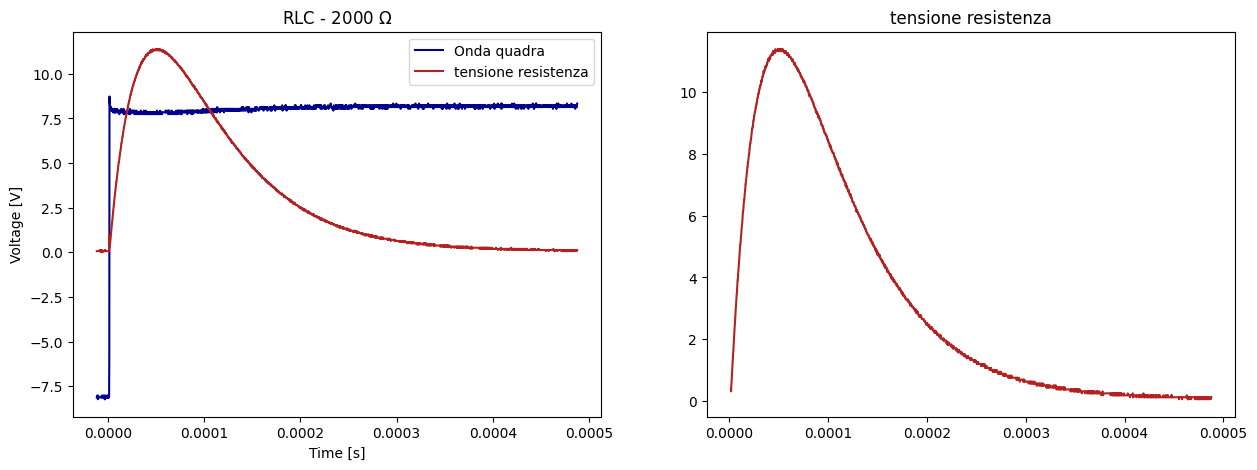

In [225]:
RLC_2000_quadra, RLC_2000_res, RLC_2000_ind = get_data("data/RLC_2000/")
if RLC_2000_ind[1] == None:   RLC_2000_ind = RLC_2000_quadra[0], (RLC_2000_quadra[1] - RLC_2000_res[1])

cut = True

i = 0
if cut:
    v = RLC_2000_quadra[1][0]
    while(v < np.max(RLC_2000_quadra[1][:2000])):
        v = RLC_2000_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 2000 $\Omega$')
plt.plot(RLC_2000_quadra[0][:],RLC_2000_quadra[1][:], c='darkblue')
plt.plot(RLC_2000_res[0][:],  RLC_2000_res[1][:],   c='firebrick')
# plt.plot(RLC_2000_ind[0][:],  RLC_2000_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_2000_res[0][i:],  RLC_2000_res[1][i:],   c='firebrick')

In [226]:
c = LeastSquares(RLC_2000_res[0][67:], RLC_2000_res[1][67:], 0.01, V_sott)
m = Minuit(c, R=2000+R_g+R_L, L=L_int, C=C_int, fase=0, V_o=8)
# m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [True, True, True, False, False]
m.fixed['R', 'L', 'C', 'fase', 'V_o'] = [False, False, False, False, False]
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.852e+05 (χ²/ndof = 158.7)│              Nfcn = 858              │
│ EDM = 3.92e+04 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  10.75e3  │  0.04e3   │            │            │         │         │       │
│ 1 │ L    │ 280.3e-3  │  1.0e-3   │            │            │         │         │       │
│ 2 │ C    │ 390.6e-9  │  1.1e-9   │            │            │         │         │       │
│ 3 │ fase │ -1.41594  │  0.00025  │            │            │         │         │       │
│ 4 │ V_o  │   2.413   │   0.004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│      │                 R                 L                 C              fase               V_o │
├──────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│    R │          1.39e+03        35.6407e-3 -22.0955712337e-9       -5.72892e-3        -85.981e-3 │
│    L │        35.6407e-3          9.17e-07     -581.5067e-15          -0.14e-6           -2.2e-6 │
│    C │ -22.0955712337e-9     -581.5067e-15          1.31e-18     -100.8681e-15    -1.5593982e-12 │
│ fase │       -5.72892e-3          -0.14e-6     -100.8681e-15          6.24e-08           0.94e-6 │
│  V_o │        -85.981e-3           -2.2e-6    -1.5593982e-12           0.94e-6          1.43e-05 │
└──────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [227]:
c = LeastSquares(RLC_2000_res[0][67:], RLC_2000_res[1][67:], 0.1, V_crit)
m = Minuit(c, R=2000+R_g+R_L, L=0.060, V_o=8)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3344 (χ²/ndof = 1.4)       │              Nfcn = 153              │
│ EDM = 1e-05 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  1.035e3  │  0.004e3  │            │            │         │         │       │
│ 1 │ L    │ 26.77e-3  │  0.10e-3  │            │            │         │         │       │
│ 2 │ V_o  │ 1.523e-6  │ 0.006e-6  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────────────────────────────┐
│     │                R                L              V_o │
├─────┼────────────────────────────────────────────────────┤
│   R │             14.3       370.259e-6 -21.062723135e-9 │
│   L │       370.259e-6         9.72e-09     -539.154e-15 │
│ V_o │ -21.062723135e-9     -539.154e-15         3.14e-17 │
└─────┴────────────────────────────────────────────────────┘

# R = 3000 $\Omega$

67


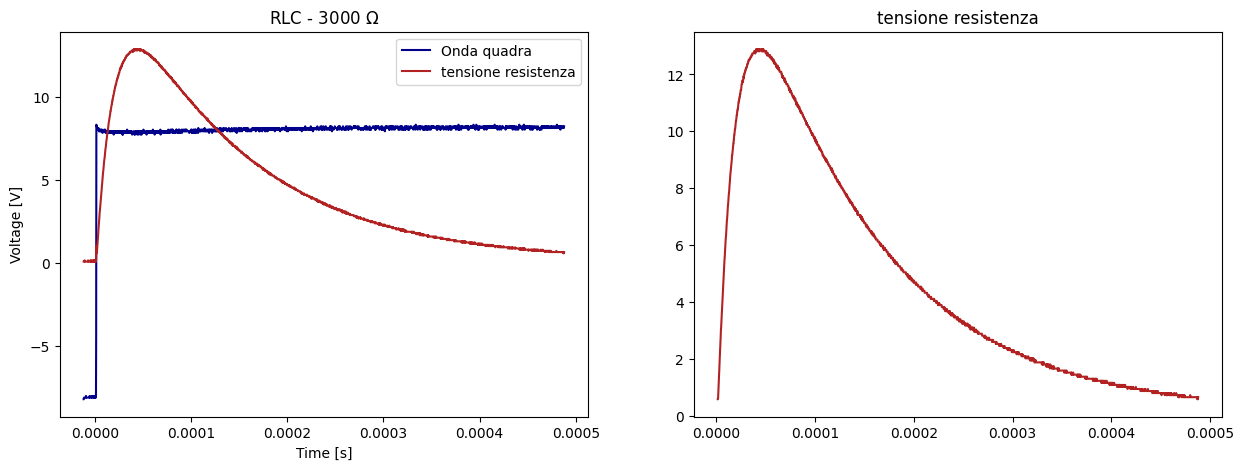

In [228]:
RLC_3000_quadra, RLC_3000_res, RLC_3000_ind = get_data("data/RLC_3000/")
if RLC_3000_ind[1] == None:   RLC_3000_ind = RLC_3000_quadra[0], (RLC_3000_quadra[1] - RLC_3000_res[1])

cut = True

i = 0
if cut:
    v = RLC_3000_quadra[1][0]
    while(v < np.max(RLC_3000_quadra[1][:3000])):
        v = RLC_3000_quadra[1][i]
        i+=1
    print(i)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plt.title('RLC - 3000 $\Omega$')
plt.plot(RLC_3000_quadra[0][:],RLC_3000_quadra[1][:], c='darkblue')
plt.plot(RLC_3000_res[0][:],  RLC_3000_res[1][:],   c='firebrick')
# plt.plot(RLC_3000_ind[0][:],  RLC_3000_ind[1][:],   c='darkblue')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione induttore'])

plt.subplot(122)
plt.title('tensione resistenza')
plt.plot(RLC_3000_res[0][i:],  RLC_3000_res[1][i:],   c='firebrick')

In [229]:
c = LeastSquares(RLC_3000_res[0][67:], RLC_3000_res[1][67:], 0.1, V_sovr2)
m = Minuit(c, R=3000+R_g+R_L, L=L_int, C=C_int, I_o=3.514e-3	)
m.limits['R', 'L', 'C'] = (0, np.inf)
m.fixed['R'] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3025 (χ²/ndof = 1.2)       │              Nfcn = 96               │
│ EDM = 1.53e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  3.089e3  │  0.031e3  │            │            │    0    │         │  yes  │
│ 1 │ L    │ 53.80e-3  │  0.08e-3  │            │            │    0    │         │       │
│ 2 │ C    │ 50.167e-9 │ 0.034e-9  │            │            │    0    │         │       │
│ 3 │ I_o  │ 6.737e-3  │ 0.007e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────┐
│     │              R              L              C            I_o │
├─────┼─────────────────────────────────────────────────────────────┤
│   R │              0           0e-9              0              0 │
│   L │           0e-9       6.67e-09 -1.2567920e-15        0.49e-9 │
│   C │              0 -1.2567920e-15       1.19e-21  -208.7562e-18 │
│ I_o │              0        0.49e-9  -208.7562e-18       5.54e-11 │
└─────┴─────────────────────────────────────────────────────────────┘

In [230]:
print(f'R = {round(3000+R_g+R_L - m.values["R"],1)} \n L = {round((L_int - m.values["L"])*1e3,1)} mH \nC = {round((C_int - m.values["C"])*1e9,1)} nF')

R = 0.0 
 L = -1.4 mH 
C = -0.8 nF


#

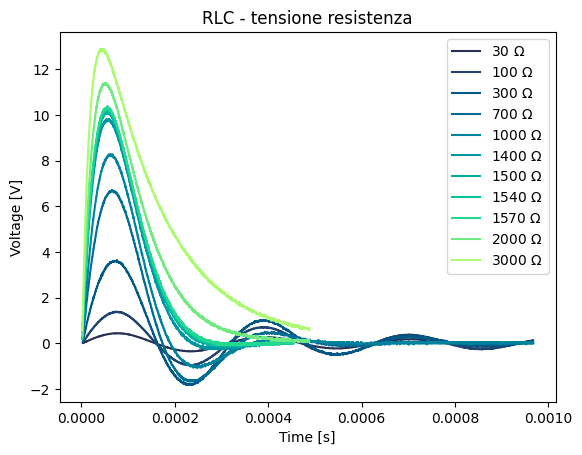

In [231]:
plt.plot(RLC_30_res[0][87:], RLC_30_res[1][87:], c='#292f56', label='30 $\Omega$')
plt.plot(RLC_100_res[0][87:], RLC_100_res[1][87:], c='#204370', label='100 $\Omega$')
plt.plot(RLC_300_res[0][87:], RLC_300_res[1][87:], c='#005886', label='300 $\Omega$')
plt.plot(RLC_700_res[0][87:], RLC_700_res[1][87:], c='#006d95', label='700 $\Omega$')
plt.plot(RLC_1000_res[0][87:], RLC_1000_res[1][87:], c='#00829d', label='1000 $\Omega$')
plt.plot(RLC_1400_res[0][237:], RLC_1400_res[1][237:], c='#0097a3', label='1400 $\Omega$')
plt.plot(RLC_1500_res[0][237:], RLC_1500_res[1][237:], c='#00ada4', label='1500 $\Omega$')
plt.plot(RLC_1540_res[0][237:], RLC_1540_res[1][237:], c='#00c49e', label='1540 $\Omega$')
plt.plot(RLC_1570_res[0][237:], RLC_1570_res[1][237:], c='#23d890', label='1570 $\Omega$')
plt.plot(RLC_2000_res[0][67:], RLC_2000_res[1][67:], c='#70ea80', label='2000 $\Omega$')
plt.plot(RLC_3000_res[0][67:], RLC_3000_res[1][67:], c='#acfa70', label='3000 $\Omega$')
plt.title('RLC - tensione resistenza')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.savefig('imgs/RLC/RLC_all.pdf',bbox_inches='tight')

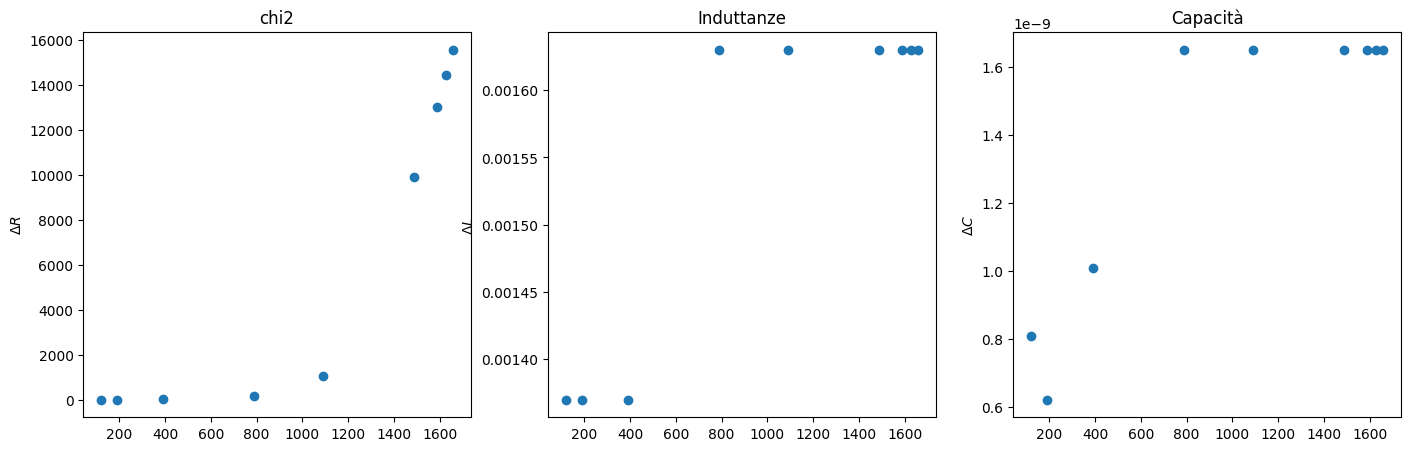

In [232]:
Rs,Ls,Cs = np.array([30,100,300,700,1000,1400,1500,1540,1570]), np.array([L_int,L_int,L_int,L_int,L_int,L_int,L_int,L_int,L_int]), np.array([C_int,C_int,C_int,C_int,C_int,C_int,C_int,C_int,C_int])

R_ = np.array(R)
L_ = np.array(L)
C_ = np.array(C)

plt.subplots(1,3,figsize=(17,5))

plt.subplot(131)
plt.title('chi2')
plt.ylabel('$\Delta R$')
plt.scatter(R_,chi)

plt.subplot(132)
plt.title('Induttanze')
plt.ylabel('$\Delta L$')
plt.scatter(R_,np.abs(Ls-L_))

plt.subplot(133)
plt.title('Capacità')
plt.ylabel('$\Delta C$')
plt.scatter(R_,np.abs(Cs-C_))

In [233]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

In [234]:
def exp(x, a, b, c):
    return a*np.exp(b*x) + c

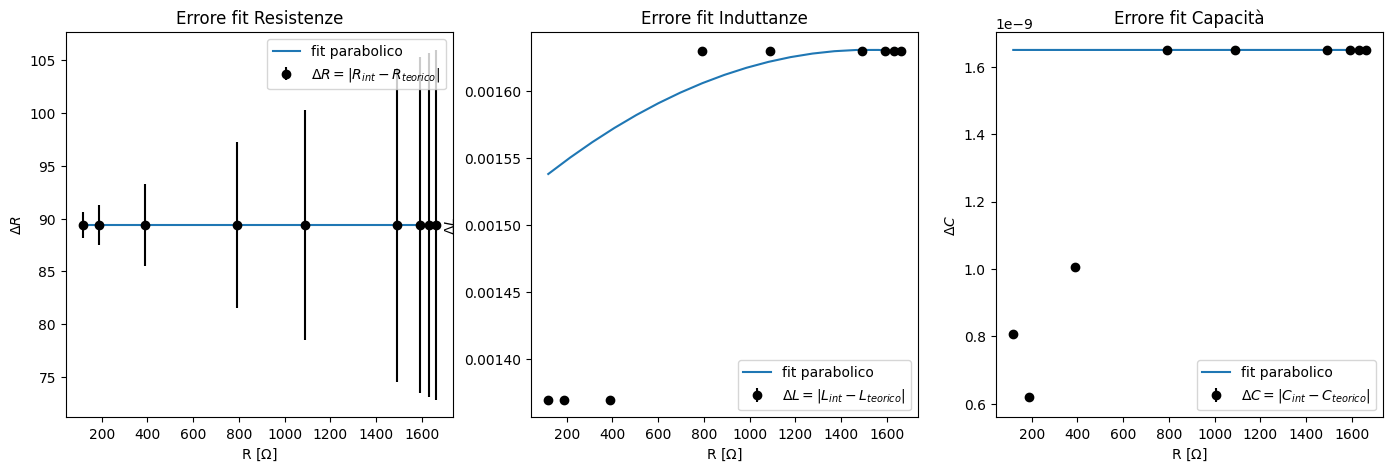

In [235]:
func = parabola

plt.subplots(1,3,figsize=(17,5))
plt.subplot(131)
plt.title('Errore fit Resistenze')
plt.ylabel('$\Delta R$')
plt.xlabel('R [$\Omega$]')
c = LeastSquares(R, np.abs(Rs-R), R_err, func)
m = Minuit(c, a=1, b=1, c=1)
m.migrad()
m.visualize()
plt.legend(['fit parabolico','$\Delta R = |R_{int} - R_{teorico}|$'])

plt.subplot(132)
plt.title('Errore fit Induttanze')
plt.ylabel('$\Delta L$')
plt.xlabel('R [$\Omega$]')
c = LeastSquares(R, np.abs(Ls-L), L_err, func)
m = Minuit(c, a=1, b=1, c=1)
m.migrad()
m.visualize()
plt.legend(['fit parabolico','$\Delta L = |L_{int} - L_{teorico}|$'])

plt.subplot(133)
plt.title('Errore fit Capacità')
plt.ylabel('$\Delta C$')
plt.xlabel('R [$\Omega$]')
c = LeastSquares(R, np.abs(Cs-C), C_err, func)
m = Minuit(c, a=1, b=1, c=1)
m.migrad()
m.visualize()
plt.legend(['fit parabolico','$\Delta C = |C_{int} - C_{teorico}|$'])

plt.savefig('imgs/RLC/RLC_sottosmorzato.pdf',bbox_inches='tight')
